# Predict Bike Sharing Demand with AutoGluon

## Install MXNet and Autogluon

In [2]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
# Without --no-cache-dir, smaller aws instances may have trouble installing

# Update jupyter and ipywidgets
!pip install -U jupyter

  Using cached pip-22.3.1-py3-none-any.whl (2.1 MB)
  Attempting uninstall: pip
    Found existing installation: pip 21.3.1
    Uninstalling pip-21.3.1:
      Successfully uninstalled pip-21.3.1
  Using cached setuptools-65.6.3-py3-none-any.whl (1.2 MB)
  Using cached wheel-0.38.4-py3-none-any.whl (36 kB)
  Attempting uninstall: wheel
    Found existing installation: wheel 0.34.2
    Uninstalling wheel-0.34.2:
      Successfully uninstalled wheel-0.34.2
  Attempting uninstall: setuptools
    Found existing installation: setuptools 59.3.0
    Uninstalling setuptools-59.3.0:
      Successfully uninstalled setuptools-59.3.0
  Using cached mxnet-1.9.1-py3-none-manylinux2014_x86_64.whl (49.1 MB)
  Using cached bokeh-2.0.1-py3-none-any.whl
  Attempting uninstall: bokeh
    Found existing installation: bokeh 2.4.2
    Uninstalling bokeh-2.4.2:
      Successfully uninstalled bokeh-2.4.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

# Setup Kaggle API and Token

In [3]:
pip install kaggle

  Using cached kaggle-1.5.12-py3-none-any.whl
  Using cached python_slugify-7.0.0-py2.py3-none-any.whl (9.4 kB)
Note: you may need to restart the kernel to use updated packages.


In [4]:
# creating the .kaggle directory 
!mkdir -p /root/.kaggle

# creating empty kaggle.json file
!touch /root/.kaggle/kaggle.json

# change file access to read-write for owner 
!chmod 600 /root/.kaggle/kaggle.json

In [5]:
# update kaggle username and key
import json
kaggle_username = "sm2020324"
kaggle_key = "eb5f1c503d91514113b45fc9f645d3b8"

In [6]:
# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

# Load the dataset into Pandas

In [7]:
# downloading bike sharing dataset zip
!kaggle competitions download -c bike-sharing-demand
# Inflate the dataset
!unzip -o bike-sharing-demand.zip

bike-sharing-demand.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [8]:
import pandas as pd
from autogluon.tabular import TabularPredictor

In [9]:
# reading training dataset
train = pd.read_csv("./train.csv")

# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train.loc[:, 'datetime'] = pd.to_datetime(train.datetime)

In [10]:
# creating the test pandas dataframe in pandas by reading the csv and parsing datetime
test = pd.read_csv('./test.csv', parse_dates=["datetime"])
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [11]:
# creating the test pandas dataframe in pandas by reading the csv and parsing datetime as we did for train and test data
submission = pd.read_csv('./sampleSubmission.csv', parse_dates=["datetime"])
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


# Train an initial model using TabularPredictor

No path specified. Models will be saved in: "AutogluonModels/ag-20230111_170733/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230111_170733/"
AutoGluon Version:  0.6.1
Python Version:     3.8.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Oct 26 20:36:53 UTC 2022
Train Data Rows:    10886
Train Data Columns: 11
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Fe

<AxesSubplot:xlabel='model'>

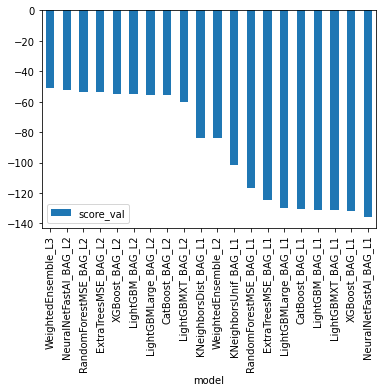

In [12]:
predictor = TabularPredictor(label="count", learner_kwargs={'ignored_columns': ["casual", "registered"]}).fit(
    train_data=train, time_limit=600, presets="best_quality"
)

# Output the model's `score_val` in a bar chart to compare performance
predictor.leaderboard(silent=True).plot(kind="bar", x="model", y="score_val")

In [14]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -50.872112      10.898344  276.802060                0.000616           0.374683            3       True         20
1   NeuralNetFastAI_BAG_L2  -52.032620       9.772534  258.705231                0.402692          38.886281            2       True         17
2   RandomForestMSE_BAG_L2  -53.466709       9.937199  233.598409                0.567357          13.779459            2       True         14
3     ExtraTreesMSE_BAG_L2  -53.837148       9.927678  223.761637                0.557836           3.942687            2       True         16
4           XGBoost_BAG_L2  -55.104014       9.470072  230.501863                0.100230          10.682913            2       True         18
5          LightGBM_BAG_L2  -55.150562       9.593454  228.521100         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'LightGBMLarge_BAG_L1': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L2': 'StackerEnsembleModel_XGBoost',
  'Ligh

In [15]:
#Create predictions from test dataset
predictions = predictor.predict(test)
predictions.head()

0    25.879786
1    41.330357
2    45.504707
3    48.367893
4    51.597679
Name: count, dtype: float32

In [16]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean      100.212814
std        88.115540
min         0.136030
25%        21.845737
50%        67.100128
75%       168.532562
max       355.893799
Name: count, dtype: float64

In [17]:
# How many negative values do we have?
predictions.lt(0).value_counts()

False    6493
Name: count, dtype: int64

In [18]:
#Set predictions to submission dataframe, save, and submit
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

# Submit predictions to Kaggle

In [19]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission-soumiya"

100%|████████████████████████████████████████| 188k/188k [00:02<00:00, 87.1kB/s]
Successfully submitted to Bike Sharing Demand

In [20]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 3

fileName                     date                 description                           status    publicScore  privateScore  
---------------------------  -------------------  ------------------------------------  --------  -----------  ------------  
submission.csv               2023-01-11 17:20:17  first raw submission-soumiya          complete  1.79095      1.79095       


# Perform EDA and create and additional feature

## Train Dataset

## Data Fields
1. datetime - hourly date + timestamp  
2. season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
3. holiday - whether the day is considered a holiday
4. workingday - whether the day is neither a weekend nor holiday
5. weather -
            1: Clear, Few clouds, Partly cloudy, Partly cloudy
            2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
            3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
            4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 



6. temp - temperature in Celsius
7. atemp - "feels like" temperature in Celsius
8. humidity - relative humidity
9. windspeed - wind speed
10. casual - number of non-registered user rentals initiated
11. registered - number of registered user rentals initiated
12. count - number of total rentals

In [21]:
# read top 5 rows of training dataset
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [22]:
# import warnings, seaborn and matplotlib for visualization

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns # import seaborn
import matplotlib.pyplot as plt  # seaborn is based on matplotlib.pyplot lib of functions
sns.set(color_codes=True) #to get color rich graphs


In [23]:
# understand structure of Data
train.describe(include='all')

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
unique,10886,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2011-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,2011-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2012-12-19 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,NaN,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,NaN,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,NaN,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000


In [24]:
# understand the shape of the dataset
train.shape

(10886, 12)

In [25]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [26]:
#get unique values for season from the taining dataset
train.season.unique()

array([1, 2, 3, 4])

In [27]:
#get unique values for holiday from the taining dataset
train.holiday.unique()

array([0, 1])

In [28]:
#get unique values for workingday from the taining dataset
train.workingday.unique()

array([0, 1])

In [29]:
#get unique values for weather from the taining dataset
train.weather.unique()

array([1, 2, 3, 4])

In [30]:
#get unique values for temp from the taining dataset
train.temp.unique()

array([ 9.84,  9.02,  8.2 , 13.12, 15.58, 14.76, 17.22, 18.86, 18.04,
       16.4 , 13.94, 12.3 , 10.66,  6.56,  5.74,  7.38,  4.92, 11.48,
        4.1 ,  3.28,  2.46, 21.32, 22.96, 23.78, 24.6 , 19.68, 22.14,
       20.5 , 27.06, 26.24, 25.42, 27.88, 28.7 , 30.34, 31.16, 29.52,
       33.62, 35.26, 36.9 , 32.8 , 31.98, 34.44, 36.08, 37.72, 38.54,
        1.64,  0.82, 39.36, 41.  ])

In [31]:
#get unique values for atemp from the taining dataset
train.atemp.unique()

array([14.395, 13.635, 12.88 , 17.425, 19.695, 16.665, 21.21 , 22.725,
       21.97 , 20.455, 11.365, 10.605,  9.85 ,  8.335,  6.82 ,  5.305,
        6.06 ,  9.09 , 12.12 ,  7.575, 15.91 ,  3.03 ,  3.79 ,  4.545,
       15.15 , 18.18 , 25.   , 26.515, 27.275, 29.545, 23.485, 25.76 ,
       31.06 , 30.305, 24.24 , 18.94 , 31.82 , 32.575, 33.335, 28.79 ,
       34.85 , 35.605, 37.12 , 40.15 , 41.665, 40.91 , 39.395, 34.09 ,
       28.03 , 36.365, 37.88 , 42.425, 43.94 , 38.635,  1.515,  0.76 ,
        2.275, 43.18 , 44.695, 45.455])

In [32]:
#get unique values for humidity from the taining dataset
train.humidity.unique()

array([ 81,  80,  75,  86,  76,  77,  72,  82,  88,  87,  94, 100,  71,
        66,  57,  46,  42,  39,  44,  47,  50,  43,  40,  35,  30,  32,
        64,  69,  55,  59,  63,  68,  74,  51,  56,  52,  49,  48,  37,
        33,  28,  38,  36,  93,  29,  53,  34,  54,  41,  45,  92,  62,
        58,  61,  60,  65,  70,  27,  25,  26,  31,  73,  21,  24,  23,
        22,  19,  15,  67,  10,   8,  12,  14,  13,  17,  16,  18,  20,
        85,   0,  83,  84,  78,  79,  89,  97,  90,  96,  91])

In [33]:
#get unique values for windspeed from the taining dataset
train.windspeed.unique()

array([ 0.    ,  6.0032, 16.9979, 19.0012, 19.9995, 12.998 , 15.0013,
        8.9981, 11.0014, 22.0028, 30.0026, 23.9994, 27.9993, 26.0027,
        7.0015, 32.9975, 36.9974, 31.0009, 35.0008, 39.0007, 43.9989,
       40.9973, 51.9987, 46.0022, 50.0021, 43.0006, 56.9969, 47.9988])

In [34]:
#get unique values for casual from the taining dataset
train.casual.unique()

array([  3,   8,   5,   0,   2,   1,  12,  26,  29,  47,  35,  40,  41,
        15,   9,   6,  11,   4,   7,  16,  20,  19,  10,  13,  14,  18,
        17,  21,  33,  23,  22,  28,  48,  52,  42,  24,  30,  27,  32,
        58,  62,  51,  25,  31,  59,  45,  73,  55,  68,  34,  38, 102,
        84,  39,  36,  43,  46,  60,  80,  83,  74,  37,  70,  81, 100,
        99,  54,  88,  97, 144, 149, 124,  98,  50,  72,  57,  71,  67,
        95,  90, 126, 174, 168, 170, 175, 138,  92,  56, 111,  89,  69,
       139, 166, 219, 240, 147, 148,  78,  53,  63,  79, 114,  94,  85,
       128,  93, 121, 156, 135, 103,  44,  49,  64,  91, 119, 167, 181,
       179, 161, 143,  75,  66, 109, 123, 113,  65,  86,  82, 132, 129,
       196, 142, 122, 106,  61, 107, 120, 195, 183, 206, 158, 137,  76,
       115, 150, 188, 193, 180, 127, 154, 108,  96, 110, 112, 169, 131,
       176, 134, 162, 153, 210, 118, 141, 146, 159, 178, 177, 136, 215,
       198, 248, 225, 194, 237, 242, 235, 224, 236, 222,  77,  8

In [35]:
#get unique values for registered from the taining dataset
train.registered.unique()

array([ 13,  32,  27,  10,   1,   0,   2,   7,   6,  24,  30,  55,  47,
        71,  70,  52,  26,  31,  25,  17,  16,   8,   4,  19,  46,  54,
        73,  64,  67,  58,  43,  29,  20,   9,   5,   3,  63, 153,  81,
        33,  41,  48,  53,  66, 146, 148, 102,  49,  11,  36,  92, 177,
        98,  37,  50,  79,  68, 202, 179, 110,  34,  87, 192, 109,  74,
        65,  85, 186, 166, 127,  82,  40,  18,  95, 216, 116,  42,  57,
        78,  59, 163, 158,  51,  76, 190, 125, 178,  39,  14,  15,  56,
        60,  90,  83,  69,  28,  35,  22,  12,  77,  44,  38,  75, 184,
       174, 154,  97, 214,  45,  72, 130,  94, 139, 135, 197, 137, 141,
       156, 117, 155, 134,  89,  80, 108,  61, 124, 132, 196, 107, 114,
       172, 165, 105, 119, 183, 175,  88,  62,  86, 170, 145, 217,  91,
       195, 152,  21, 126, 115, 223, 207, 123, 236, 128, 151, 100, 198,
       157, 168,  84,  99, 173, 121, 159,  93,  23, 212, 111, 193, 103,
       113, 122, 106,  96, 249, 218, 194, 213, 191, 142, 224, 24

In [36]:
from matplotlib.pyplot import figure
train.corr()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
season,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,0.096758,0.164011,0.163439
holiday,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,0.043799,-0.020956,-0.005393
workingday,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,-0.319111,0.119460,0.011594
weather,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.135918,-0.109340,-0.128655
temp,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.467097,0.318571,0.394454
atemp,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.462067,0.314635,0.389784
humidity,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.348187,-0.265458,-0.317371
windspeed,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.092276,0.091052,0.101369
casual,0.096758,0.043799,-0.319111,-0.135918,0.467097,0.462067,-0.348187,0.092276,1.000000,0.497250,0.690414
registered,0.164011,-0.020956,0.119460,-0.109340,0.318571,0.314635,-0.265458,0.091052,0.497250,1.000000,0.970948


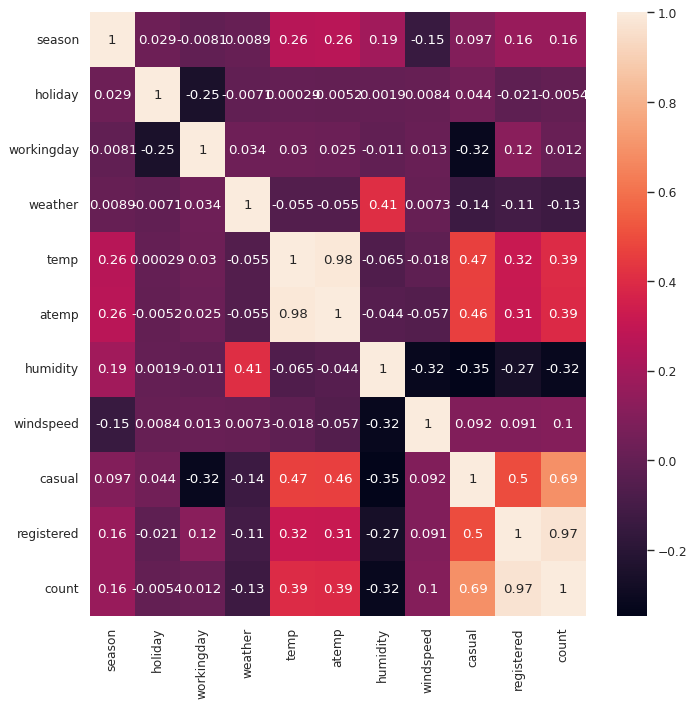

In [37]:

figure(figsize=(10,10), dpi=80)
corr = train.corr()
sns.heatmap(corr, annot=True); #correlation matrix between different columns

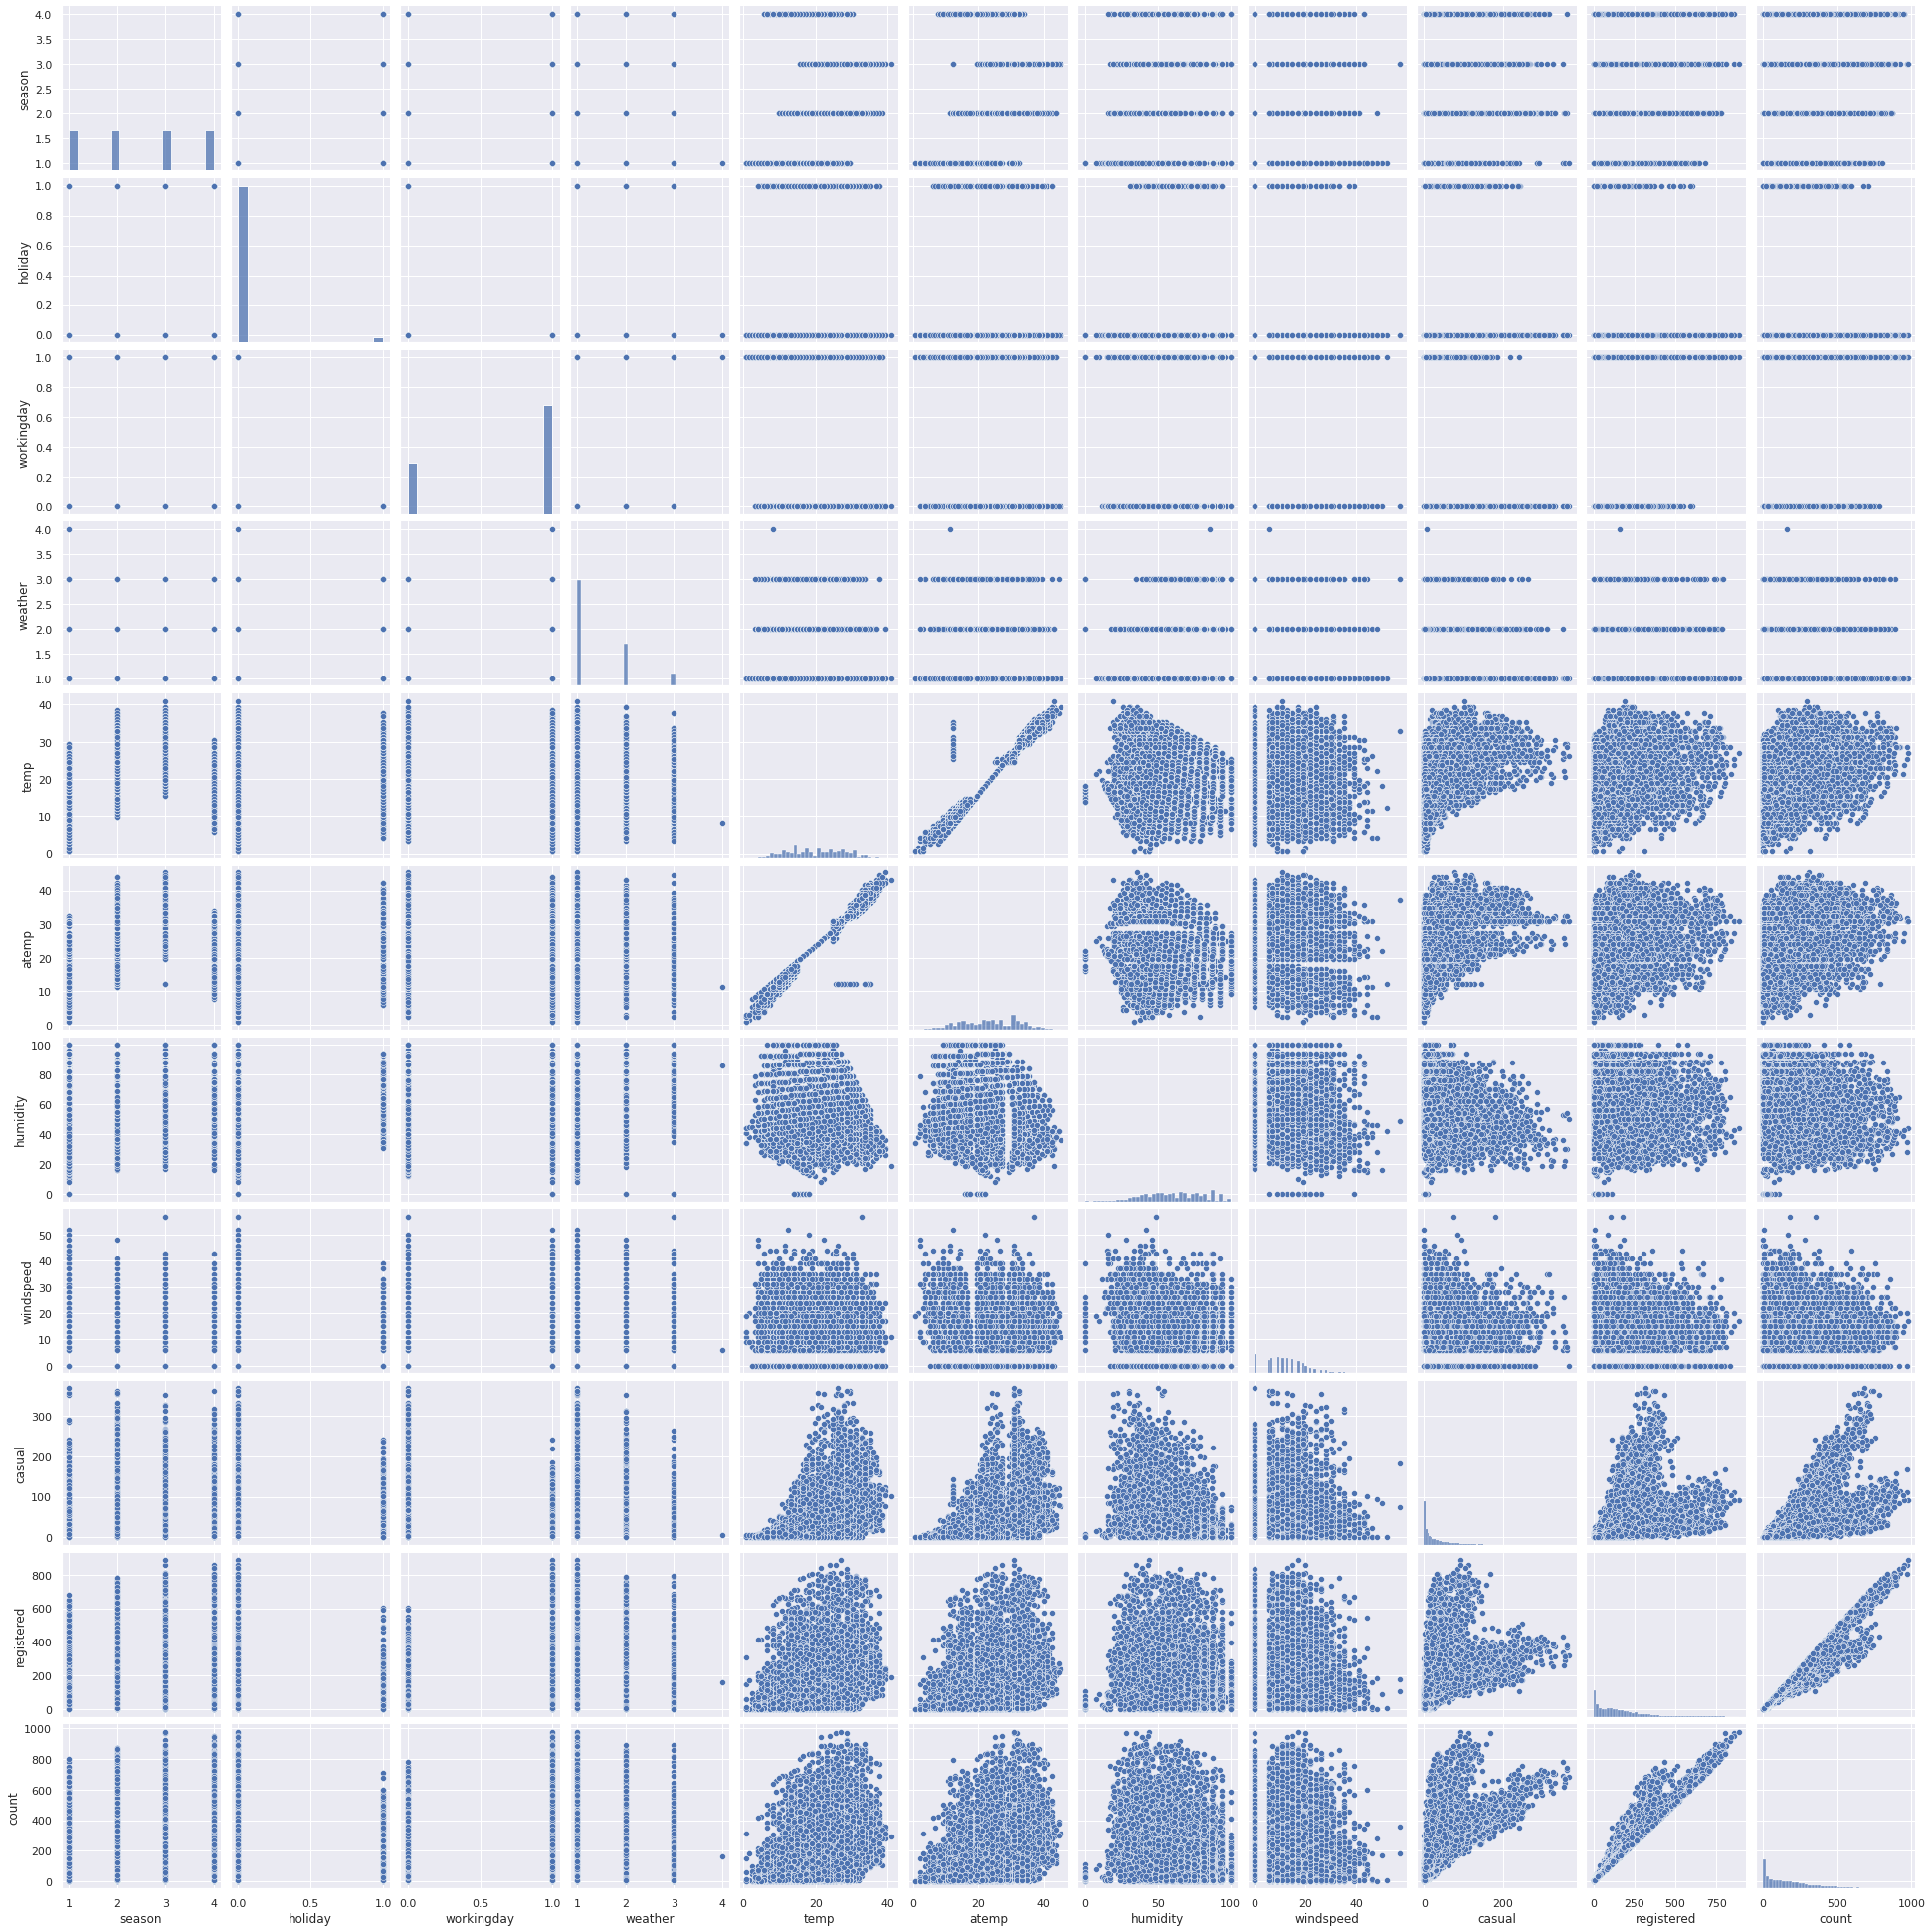

In [38]:
#Multivariate Data Analysis and Visualization
sns.pairplot(train); # relationship between different numeric data columns

## EDA (train dataset)

1. Training dataset has 10,886 rows of data and 12 features
2. Mean temp and temp values are 20.2 Celsius and 23.6 Celsius respectively
3. Temp varies between 0-40 Celsius
4. Mean relative humidity is 61 and valor between 0-100
5. Mean windspeed is 12.7 and varies between 0 to 56.9
6. All the features have no null values
7. There are four unique values representing seasons for the season feature. We will convert this to category type as that is a better representation of that feature.
8. There are four unique values representing weather feature. We will convert this to category type as that is a better representation of that feature.
9. Holiday and Workingday have binary values. We will convert both of these features to boolean type.
10. Based on pair plot, Registered bikes are rented more and are highly correlated.
11. In medium Temperature, and humidiy bikes are rented more rather than when it’s too hot or cold or too humid.

In [39]:
# Transform columns for model training

train["season"] = train["season"].astype("category")
train["weather"] = train["weather"].astype("category")
train["holiday"] = train["holiday"].astype("bool")
train["workingday"] = train["workingday"].astype("bool")

In [40]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  category      
 2   holiday     10886 non-null  bool          
 3   workingday  10886 non-null  bool          
 4   weather     10886 non-null  category      
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: bool(2), category(2), datetime64[ns](1), float64(3), int64(4)
memory usage: 723.4 KB


In [41]:
# Transform columns for model test data

test["season"] = test["season"].astype("category")
test["weather"] = test["weather"].astype("category")
test["holiday"] = test["holiday"].astype("bool")
test["workingday"] = test["workingday"].astype("bool")

In [42]:
# creating a new features by splitting datetime into month, day, year features and we will drop datetime feature, 
# this transformation will be applied to both test and train datasets

train["year"] = train.datetime.dt.year
train["month"] = train.datetime.dt.month
train["day"] = train.datetime.dt.day
train.drop(["datetime"], axis=1, inplace=True)

test["year"] = test.datetime.dt.year
test["month"] = test.datetime.dt.month
test["day"] = test.datetime.dt.day
test.drop(["datetime"], axis=1, inplace=True)

train.head()
test.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day
0,1,False,True,1,10.66,11.365,56,26.0027,2011,1,20
1,1,False,True,1,10.66,13.635,56,0.0000,2011,1,20
2,1,False,True,1,10.66,13.635,56,0.0000,2011,1,20
3,1,False,True,1,10.66,12.880,56,11.0014,2011,1,20
4,1,False,True,1,10.66,12.880,56,11.0014,2011,1,20


## Retrain model with new features and then will submit this to kaggle again.

No path specified. Models will be saved in: "AutogluonModels/ag-20230111_172742/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230111_172742/"
AutoGluon Version:  0.6.1
Python Version:     3.8.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Oct 26 20:36:53 UTC 2022
Train Data Rows:    10886
Train Data Columns: 13
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Fe

<AxesSubplot:xlabel='model'>

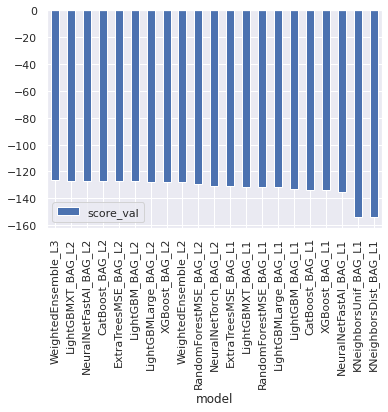

In [43]:
predictor_new_features = TabularPredictor(label="count", learner_kwargs={'ignored_columns': ["casual", "registered"]}).fit(
    train_data=train, time_limit=600, presets="best_quality"
)
# Output the model's `score_val` in a bar chart to compare performance
predictor_new_features.leaderboard(silent=True).plot(kind="bar", x="model", y="score_val")

In [44]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3 -126.143071       8.754152  355.694520                0.000745           0.443869            3       True         21
1        LightGBMXT_BAG_L2 -126.996936       7.491665  298.738460                0.158835           7.392100            2       True         12
2   NeuralNetFastAI_BAG_L2 -127.263471       7.697212  330.487486                0.364382          39.141126            2       True         17
3          CatBoost_BAG_L2 -127.318016       7.428025  314.307783                0.095195          22.961423            2       True         15
4     ExtraTreesMSE_BAG_L2 -127.446443       7.889632  295.146484                0.556801           3.800124            2       True         16
5          LightGBM_BAG_L2 -127.512480       7.446385  299.052870         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'LightGBMLarge_BAG_L1': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L2': 'StackerEnsembleModel_XGBoost',
  'Neur

In [45]:
predictions_new_features = predictor_new_features.predict(test)
predictions_new_features.head()

0    81.983315
1    72.344429
2    72.344429
3    79.645905
4    79.645905
Name: count, dtype: float32

In [46]:
# setting negative values to zero
predictions_new_features[predictions_new_features < 0] = 0
print("New Array :")
predictions_new_features

New Array :


0        81.983315
1        72.344429
2        72.344429
3        79.645905
4        79.645905
           ...    
6488    180.399933
6489    180.399933
6490    171.010345
6491    154.024612
6492    134.626709
Name: count, Length: 6493, dtype: float32

In [47]:
submission_new_features = pd.read_csv('./sampleSubmission.csv', parse_dates=["datetime"])
submission_new_features["count"] = predictions_new_features
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [48]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

100%|█████████████████████████████████████████| 188k/188k [00:01<00:00, 114kB/s]
Successfully submitted to Bike Sharing Demand

In [49]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 4

fileName                     date                 description                           status    publicScore  privateScore  
---------------------------  -------------------  ------------------------------------  --------  -----------  ------------  
submission_new_features.csv  2023-01-11 17:49:50  new features                          complete  1.33117      1.33117       
submission.csv               2023-01-11 17:20:17  first raw submission-soumiya          complete  1.79095      1.79095       


# Hyperparameter Optimization

No path specified. Models will be saved in: "AutogluonModels/ag-20230111_174952/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=5, num_bag_sets=1
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230111_174952/"
AutoGluon Version:  0.6.1
Python Version:     3.8.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Oct 26 20:36:53 UTC 2022
Train Data Rows:    10886
Train Data Columns: 13
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Fea

<AxesSubplot:xlabel='model'>

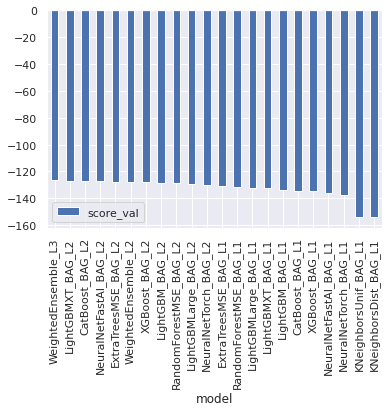

In [50]:
import autogluon.core as ag

predictor_new_hpo = TabularPredictor(label="count", eval_metric=None, learner_kwargs={'ignored_columns': ["casual", "registered"]}).fit(
    train_data=train, time_limit=600, num_bag_folds=5, num_bag_sets=1, num_stack_levels=1, presets="best_quality"
)

# Output the model's `score_val` in a bar chart to compare performance
predictor_new_hpo.leaderboard(silent=True).plot(kind="bar", x="model", y="score_val")

In [51]:
predictor_new_hpo.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3 -126.226407       7.386559  316.344394                0.000638           0.417858            3       True         22
1        LightGBMXT_BAG_L2 -126.935132       6.282938  243.941841                0.112470           5.205694            2       True         13
2          CatBoost_BAG_L2 -127.343768       6.225463  253.915327                0.054995          15.179180            2       True         16
3   NeuralNetFastAI_BAG_L2 -127.346516       6.444419  268.237014                0.273951          29.500867            2       True         18
4     ExtraTreesMSE_BAG_L2 -127.532348       6.732165  242.638187                0.561697           3.902041            2       True         17
5      WeightedEnsemble_L2 -127.979428       4.717934  131.115356         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'NeuralNetTorch_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'LightGBMLarge_BAG_L1': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFa

In [52]:
predictions_new_hpo = predictor_new_hpo.predict(test)
predictions_new_hpo.iloc[predictions_new_hpo.lt(0)] = 0


In [53]:
# setting negative values to zero
predictions_new_hpo[predictions_new_hpo < 0] = 0
print("New Array :")
predictions_new_hpo

New Array :


0        82.084717
1        67.371239
2        67.371239
3        73.725601
4        73.725601
           ...    
6488    173.426132
6489    173.426132
6490    150.646301
6491    148.267456
6492    137.889908
Name: count, Length: 6493, dtype: float32

In [54]:
submission_new_hpo = pd.read_csv('./sampleSubmission.csv', parse_dates=["datetime"])
submission_new_hpo["count"] = predictions_new_hpo
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

In [55]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

100%|████████████████████████████████████████| 188k/188k [00:02<00:00, 91.5kB/s]
Successfully submitted to Bike Sharing Demand

In [56]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 5

fileName                     date                 description                           status    publicScore  privateScore  
---------------------------  -------------------  ------------------------------------  --------  -----------  ------------  
submission_new_hpo.csv       2023-01-11 17:57:03  new features with hyperparameters     complete  1.32531      1.32531       
submission_new_features.csv  2023-01-11 17:49:50  new features                          complete  1.33117      1.33117       
submission.csv               2023-01-11 17:20:17  first raw submission-soumiya          complete  1.79095      1.79095       


No path specified. Models will be saved in: "AutogluonModels/ag-20230111_175705/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=2, num_bag_folds=10, num_bag_sets=2
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230111_175705/"
AutoGluon Version:  0.6.1
Python Version:     3.8.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Oct 26 20:36:53 UTC 2022
Train Data Rows:    10886
Train Data Columns: 13
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Fe

<AxesSubplot:xlabel='model'>

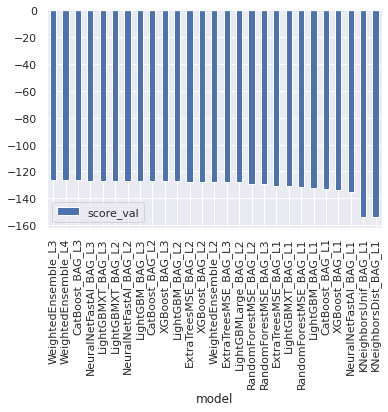

In [57]:
import autogluon.core as ag

predictor_new_hpo2 = TabularPredictor(label="count", eval_metric=None, learner_kwargs={'ignored_columns': ["casual", "registered"]}).fit(
    train_data=train, time_limit=600, num_bag_folds=10, num_bag_sets=2, num_stack_levels=2, presets="best_quality"
)

# Output the model's `score_val` in a bar chart to compare performance
predictor_new_hpo2.leaderboard(silent=True).plot(kind="bar", x="model", y="score_val")

In [58]:
predictor_new_hpo2.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3 -126.061356       9.388319  342.898294                0.000631           0.398806            3       True         19
1      WeightedEnsemble_L4 -126.215396      11.516344  501.620167                0.000952           0.950477            4       True         27
2          CatBoost_BAG_L3 -126.404329      10.329959  427.049579                0.103137          23.203955            3       True         23
3   NeuralNetFastAI_BAG_L3 -126.785751      10.639413  452.550441                0.412591          48.704817            3       True         25
4        LightGBMXT_BAG_L3 -126.802992      10.340064  413.949552                0.113242          10.103928            3       True         20
5        LightGBMXT_BAG_L2 -126.863744       8.108134  256.136392         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L2': 'StackerEnsembleModel_XGBoost',
  'LightGBMLarge_BAG_L2': 'StackerEnsembleModel_LGB',
  'Weig

In [59]:
predictions_new_hpo2 = predictor_new_hpo2.predict(test)
predictions_new_hpo2.iloc[predictions_new_hpo2.lt(0)] = 0


In [60]:
# setting negative values to zero
predictions_new_hpo2[predictions_new_hpo2 < 0] = 0
print("New Array :")
predictions_new_hpo2

New Array :


0        80.824478
1        66.092964
2        66.092964
3        73.426414
4        73.426414
           ...    
6488    169.447327
6489    169.447327
6490    164.494095
6491    146.758255
6492    146.223770
Name: count, Length: 6493, dtype: float32

In [61]:
submission_new_hpo2 = pd.read_csv('./sampleSubmission.csv', parse_dates=["datetime"])
submission_new_hpo2["count"] = predictions_new_hpo2
submission_new_hpo2.to_csv("submission_new_hpo2.csv", index=False)

In [62]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo2.csv -m "new features with hyperparameters v2"

100%|████████████████████████████████████████| 188k/188k [00:02<00:00, 84.7kB/s]
Successfully submitted to Bike Sharing Demand

In [63]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                           status    publicScore  privateScore  
---------------------------  -------------------  ------------------------------------  --------  -----------  ------------  
submission_new_hpo2.csv      2023-01-11 18:07:34  new features with hyperparameters v2  complete  1.32230      1.32230       
submission_new_hpo.csv       2023-01-11 17:57:03  new features with hyperparameters     complete  1.32531      1.32531       
submission_new_features.csv  2023-01-11 17:49:50  new features                          complete  1.33117      1.33117       
submission.csv               2023-01-11 17:20:17  first raw submission-soumiya          complete  1.79095      1.79095       


# Fourth model with hyperparameter and hyperparameter_tune_kwargs attributes

In [64]:
hyperparameters = {'GBM': {'num_boost_round': 1000, 'learning_rate': ag.Real(0.01, 0.1, log=True)},
    'XGB': {'n_estimators': 1000, 'learning_rate': ag.Real(0.01, 0.1, log=True)}
}

No path specified. Models will be saved in: "AutogluonModels/ag-20230111_183511/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=5, num_bag_sets=1
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230111_183511/"
AutoGluon Version:  0.6.1
Python Version:     3.8.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Oct 26 20:36:53 UTC 2022
Train Data Rows:    10886
Train Data Columns: 13
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Fea

<AxesSubplot:xlabel='model'>

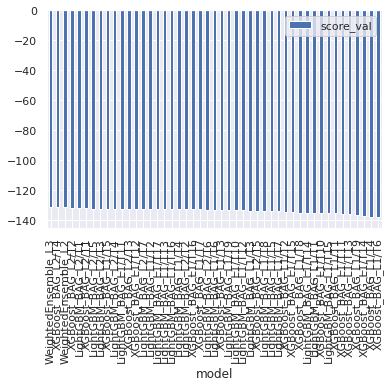

In [72]:
import autogluon.core as ag

predictor_new_hpo3 = TabularPredictor(label="count", eval_metric=None, learner_kwargs={'ignored_columns': ["casual", "registered"]}).fit(
    train_data=train, hyperparameters=hyperparameters, hyperparameter_tune_kwargs='auto', time_limit=600, num_bag_folds=5, num_bag_sets=1, num_stack_levels=1, presets="best_quality"
)

# Output the model's `score_val` in a bar chart to compare performance
predictor_new_hpo3.leaderboard(silent=True).plot(kind="bar", x="model", y="score_val")

In [73]:
predictor_new_hpo3.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                  model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L3 -131.112760       0.005034  457.851502                0.000638           0.458369            3       True         47
1     XGBoost_BAG_L2/T4 -131.246910       0.003873  364.660114                0.000110          11.133697            2       True         45
2   WeightedEnsemble_L2 -131.281035       0.001255   66.529768                0.000640           0.466070            2       True         34
3     XGBoost_BAG_L2/T2 -131.703570       0.003844  368.010759                0.000082          14.484342            2       True         43
4    LightGBM_BAG_L2/T1 -131.754773       0.003886  367.824649                0.000123          14.298232            2       True         35
5     XGBoost_BAG_L2/T1 -131.945179       0.003876  380.735061                0.000113      

{'model_types': {'LightGBM_BAG_L1/T1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T3': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T4': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T5': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T6': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T7': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T8': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T9': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T10': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T11': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T12': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T13': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T14': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T15': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T16': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T17': 'StackerEnsembleModel_LGB',
  'XGBoost_BAG_L1/T1': 'StackerEnsembleModel_XGBoost',
  'XGBoost_BAG_L1/T2': 'StackerEnsembl

In [74]:
predictions_new_hpo3 = predictor_new_hpo3.predict(test)
predictions_new_hpo3.iloc[predictions_new_hpo3.lt(0)] = 0


In [75]:
# setting negative values to zero
predictions_new_hpo3[predictions_new_hpo3 < 0] = 0
print("New Array :")
predictions_new_hpo3

New Array :


0        92.937881
1        61.094372
2        61.094372
3        67.507172
4        67.507172
           ...    
6488    181.096298
6489    181.096298
6490    172.130798
6491    151.141266
6492    141.299042
Name: count, Length: 6493, dtype: float32

In [76]:
submission_new_hpo3 = pd.read_csv('./sampleSubmission.csv', parse_dates=["datetime"])
submission_new_hpo3["count"] = predictions_new_hpo3
submission_new_hpo3.to_csv("submission_new_hpo3.csv", index=False)

In [77]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo3.csv -m "new features with hyperparameters v3"

100%|████████████████████████████████████████| 188k/188k [00:02<00:00, 87.6kB/s]
Successfully submitted to Bike Sharing Demand

In [82]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 3

fileName                     date                 description                           status    publicScore  privateScore  
---------------------------  -------------------  ------------------------------------  --------  -----------  ------------  
submission_new_hpo3.csv      2023-01-11 18:45:52  new features with hyperparameters v3  complete  1.32147      1.32147       


# Model Evaluation Visualization

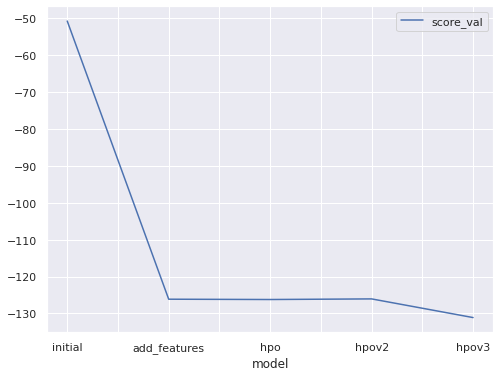

In [87]:
# Taking the top model score_val from leaderboard of rach model run and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo", "hpov2", "hpov3"],
        "score_val": [-50.872112, -126.143071, -126.226407,-126.061356 ,-131.112760 ]
    }
).plot(x="model", y="score_val", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score_val.png')

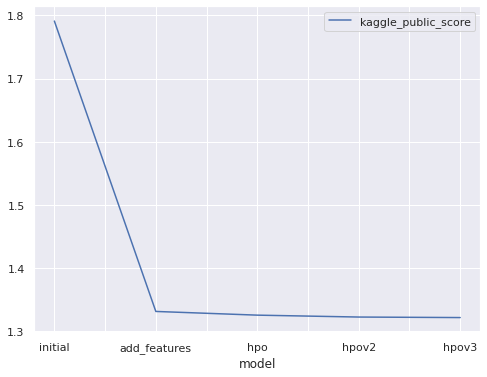

In [85]:
# Taking the top model public score from each training run and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo", "hpov2", "hpov3"],
        "kaggle_public_score": [1.79095, 1.33117, 1.32531,1.32230,1.32147]
    }
).plot(x="model", y="kaggle_public_score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_kaggle_score.png')

In [81]:
# The 3 hyperparameters we tuned with the kaggle score as the result

pd.DataFrame({
    "model": ["initial", "add_features", "hpo", "hpov2","hp0v3"],
    "num_bag_folds": [0, 0, 5, 10, 5],
    "num_bag_sets": [20, 20, 1, 2, 1],
    "num_stack_levels": [0, 0, 1, 2, 1],
    "score": [1.79095, 1.33117, 1.32531, 1.32230, 1.32147]
})

,model,num_bag_folds,num_bag_sets,num_stack_levels,score
0,initial,0,20,0,1.79095
1,add_features,0,20,0,1.33117
2,hpo,5,1,1,1.32531
3,hpov2,10,2,2,1.32230
4,hp0v3,5,1,1,1.32147


# Observations

1. WeightedEnsemble_L3 model is on top in the model leaderboard for all three runs.
2. Model score improved after adding new features (month, day, year) derived from datetime.
3. Hyperparameters tuning only improved the score slightly.